### Random Forest Regressor

## Import vers sql

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import ElasticNet,  Ridge, Lasso
from sklearn.model_selection import learning_curve
import joblib

In [2]:
import psycopg2
from psycopg2 import sql
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os

In [3]:
load_dotenv()

True

In [4]:
user = os.getenv("PGUSER")
password = os.getenv("PGPASSWORD")
host = os.getenv("PGHOST")
port = os.getenv("PGPORT")
database = os.getenv("PGDATABASE")

engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

In [5]:
def import_table_to_dataframe(table_name):
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, engine)
    return df

data_clean = import_table_to_dataframe("immo")
print(data_clean.head())

       price    city_name  salon  nb_rooms  nb_baths  surface_area  Ascenseur  \
0  2000000.0   Casablanca    1.0       2.0       2.0         168.0          1   
1  1195000.0   Casablanca    1.0       2.0       2.0          98.0          1   
2  1350000.0  Dar Bouazza    1.0       2.0       2.0          81.0          1   
3   900000.0   Casablanca    1.0       1.0       1.0          56.0          1   
4  3100000.0        Rabat    2.0       3.0       2.0         200.0          1   

   Balcon  Chauffage  Climatisation  ...  Meublé  Parking  Sécurité  Terrasse  \
0       1          0              0  ...       0        1         0         1   
1       1          1              1  ...       0        1         0         0   
2       1          1              1  ...       0        1         1         1   
3       0          1              1  ...       1        1         1         1   
4       1          0              0  ...       0        1         1         0   

   ville_encoded  ville_nb

## Sélection des variables explicatives

In [6]:
colonnes_selectionnees=['nb_rooms', 'nb_baths', 'Ascenseur',
                        'ville_encoded', 'ville_nb', 'equipement_tot', 'nb_tot', 'ville_encoded_m2']

## Séparation des données

In [7]:
X=data_clean[colonnes_selectionnees]
y=data_clean['price']

X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.20, random_state=42 )
y_train=y_train.ravel()
X_train.shape, y_train.shape

C:\Users\lenovo\AppData\Local\Temp\ipykernel_12352\4096771907.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_train=y_train.ravel()


((11644, 8), (11644,))

### Random Forest Regressor

In [8]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

In [9]:
param_grid = {
    'model__regressor__n_estimators': [100, 200],
    'model__regressor__max_depth': [10, 20, None],
    'model__regressor__min_samples_split': [2, 5],
    'model__regressor__min_samples_leaf': [1, 2],
    'model__regressor__max_features': ['sqrt'],
}

In [10]:
grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

In [11]:
grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres trouvés :", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs hyperparamètres trouvés : {'model__regressor__max_depth': None, 'model__regressor__max_features': 'sqrt', 'model__regressor__min_samples_leaf': 1, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 100}


In [12]:
best_model_rf = grid_search.best_estimator_

# Évaluation sur jeu train
y_pred_t = best_model_rf.predict(X_train)

mse_train = mean_squared_error(y_train, y_pred_t)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_pred_t)
r2_train = r2_score(y_train, y_pred_t)

print("\nPerformance sur jeu train :")
print(f"MSE  : {mse_train:.3f}")
print(f"RMSE : {rmse_train:.3f}")
print(f"MAE  : {mae_train:.3f}")
print(f"R²   : {r2_train:.3f}")


Performance sur jeu train :
MSE  : 161389441860.359
RMSE : 401733.048
MAE  : 221402.949
R²   : 0.744


In [13]:
# Évaluation sur jeu test
y_pred = best_model_rf.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("\nPerformance sur jeu test :")
print(f"MSE  : {mse_test:.3f}")
print(f"RMSE : {rmse_test:.3f}")
print(f"MAE  : {mae_test:.3f}")
print(f"R²   : {r2_test:.3f}")


Performance sur jeu test :
MSE  : 162179613282.003
RMSE : 402715.301
MAE  : 228925.245
R²   : 0.709


<class 'sklearn.ensemble._forest.RandomForestRegressor'>
            Feature  Importance
3     ville_encoded    0.174011
6            nb_tot    0.173749
7  ville_encoded_m2    0.160293
1          nb_baths    0.130737
2         Ascenseur    0.122502
5    equipement_tot    0.086380
0          nb_rooms    0.081426
4          ville_nb    0.070901


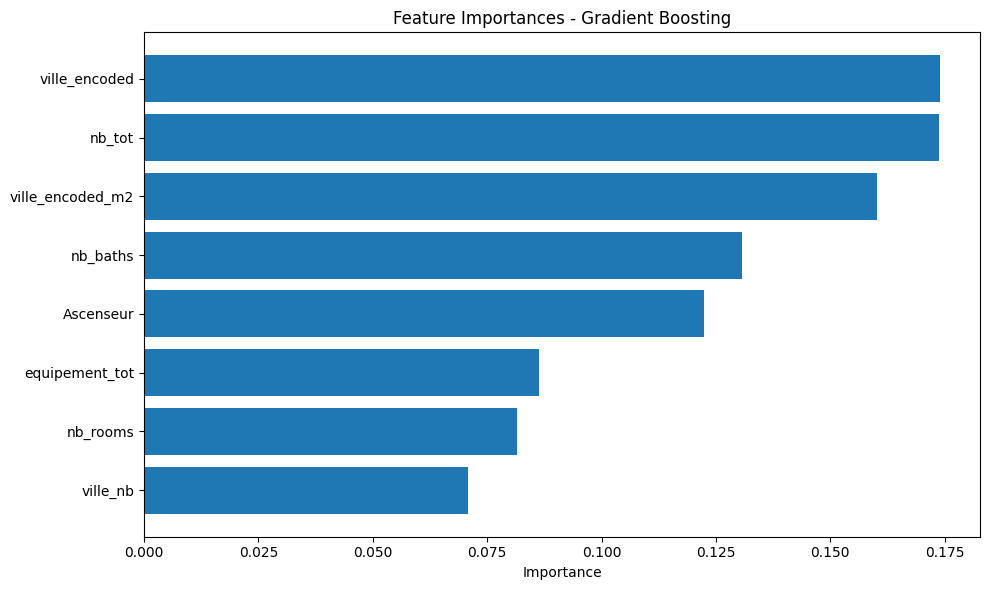

In [14]:
rf_model = best_model_rf.named_steps['model'].regressor_

print(type(rf_model))

importances = rf_model.feature_importances_
feature_names = X_train.columns


df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(df_importance)

plt.figure(figsize=(10, 6))
plt.barh(df_importance['Feature'][::-1], df_importance['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Feature Importances - Gradient Boosting")
plt.tight_layout()
plt.show()

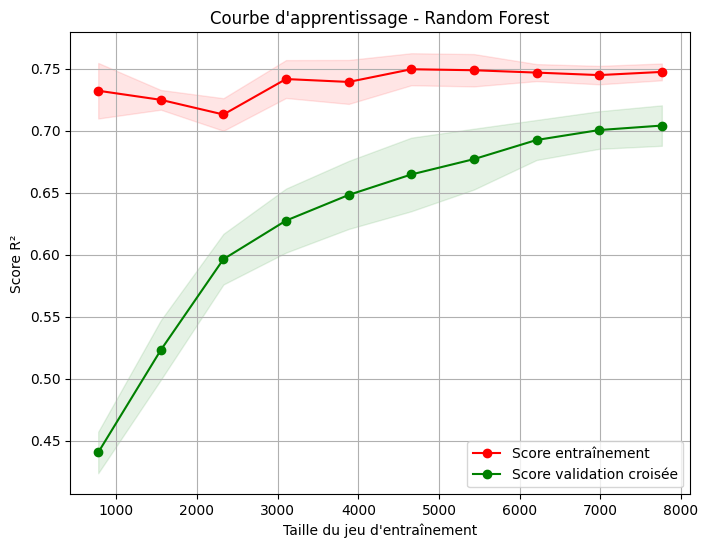

In [15]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model_rf,
    X=X_train,
    y=y_train,
    cv=3,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.title("Courbe d'apprentissage - Random Forest")
plt.xlabel("Taille du jeu d'entraînement")
plt.ylabel("Score R²")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score entraînement")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Score validation croisée")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.legend(loc="best")
plt.show()
